In [168]:
import netCDF4 as nc
from netCDF4 import Dataset
import glob
import numpy as np
import datetime
import xarray as xr
from matplotlib import pyplot as plt
from scipy import stats
import math
from datetime import date
from matplotlib.colors import LinearSegmentedColormap

[-1.80000000e+02 -1.79375000e+02 -1.78750000e+02 -1.78125000e+02
 -1.77500000e+02 -1.76875000e+02 -1.76250000e+02 -1.75625000e+02
 -1.75000000e+02 -1.74375000e+02 -1.73750000e+02 -1.73125000e+02
 -1.72500000e+02 -1.71875000e+02 -1.71250000e+02 -1.70625000e+02
 -1.70000000e+02 -1.69375000e+02 -1.68750000e+02 -1.68125000e+02
 -1.67500000e+02 -1.66875000e+02 -1.66250000e+02 -1.65625000e+02
 -1.65000000e+02 -1.64375000e+02 -1.63750000e+02 -1.63125000e+02
 -1.62500000e+02 -1.61875000e+02 -1.61250000e+02 -1.60625000e+02
 -1.60000000e+02 -1.59375000e+02 -1.58750000e+02 -1.58125000e+02
 -1.57500000e+02 -1.56875000e+02 -1.56250000e+02 -1.55625000e+02
 -1.55000000e+02 -1.54375000e+02 -1.53750000e+02 -1.53125000e+02
 -1.52500000e+02 -1.51875000e+02 -1.51250000e+02 -1.50625000e+02
 -1.50000000e+02 -1.49375000e+02 -1.48750000e+02 -1.48125000e+02
 -1.47500000e+02 -1.46875000e+02 -1.46250000e+02 -1.45625000e+02
 -1.45000000e+02 -1.44375000e+02 -1.43750000e+02 -1.43125000e+02
 -1.42500000e+02 -1.41875

In [25]:
dt_parse = '%Y%m'
def get_date_num(stri):
    date1 = datetime.datetime.strptime(stri, dt_parse)
    return(date.toordinal(date1.date()))
list_of_paths = glob.glob('C:/Users/Patrick/Desktop/175_final/global_fwi_analysis/FWI_nc\'s/*.nc', recursive=True)
nc_list = []
nc_date_list = []
nc_date_key = []
nc_date_int = []
for path in list_of_paths:
    nc_list.append(nc.Dataset(path))
    nc_date_list.append(get_date_num(path[-9:-3]))
    nc_date_key.append(path[-9:-3])

In [ ]:
normed_date = np.round(np.array(nc_date_list) - np.mean(np.array(nc_date_list)))
print(len(normed_date))

In [24]:
fwi = []
for i in nc_list:
    fwi.append(i['MERRA2_FWI'][0])
fwi_array = np.dstack(fwi)

<ipython-input-24-9e0b1f9b52d8>:3: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  fwi.append(i['MERRA2_FWI'][0])
<ipython-input-24-9e0b1f9b52d8>:3: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  fwi.append(i['MERRA2_FWI'][0])


In [158]:
years = list(range(1981, 2020))
for i in range(len(years)):
    years[i] = str(years[i])
#print(years)
yearly_list = []

for year in years:
    temp_array_list = []
    for i in range(476):
        if(nc_date_key[i][0:4] == year):
            temp_array_list.append(fwi_array[:,:,i])
    #print(len(temp_array_list))
    avg_array = np.empty((267,576))
    avg_array[:] = np.nan
    for j in range(267):
        for k in range(576):
            point_list = []
            for q in range(len(temp_array_list)):
                point_list.append(temp_array_list[q][j,k])
            avg_array[j,k] = np.nanmean(np.array(point_list))
    yearly_list.append(avg_array)
    print(str(100*(int(year) - int(years[0]))/ (int(years[-1])-int(years[0]))) + '%')

<ipython-input-158-51a2cf0d86bf>:20: RuntimeWarning: Mean of empty slice
  avg_array[j,k] = np.nanmean(np.array(point_list))


0.0%
2.6315789473684212%
5.2631578947368425%
7.894736842105263%
10.526315789473685%
13.157894736842104%
15.789473684210526%
18.42105263157895%
21.05263157894737%
23.68421052631579%
26.31578947368421%
28.94736842105263%
31.57894736842105%
34.21052631578947%
36.8421052631579%
39.473684210526315%
42.10526315789474%
44.73684210526316%
47.36842105263158%
50.0%
52.63157894736842%
55.26315789473684%
57.89473684210526%
60.526315789473685%
63.1578947368421%
65.78947368421052%
68.42105263157895%
71.05263157894737%
73.6842105263158%
76.3157894736842%
78.94736842105263%
81.57894736842105%
84.21052631578948%
86.84210526315789%
89.47368421052632%
92.10526315789474%
94.73684210526316%
97.36842105263158%
100.0%


In [159]:
year_from_start = np.array(list(range(34)))
yearly_array = np.dstack(yearly_list)

In [52]:
t_trend_slope = np.empty([267, 576])
t_trend_intercept = np.empty([267, 576])
t_trend_rvalue = np.empty([267, 576])
t_trend_pvalue = np.empty([267, 576])
t_trend_stderr = np.empty([267, 576])

t_fwi_point = np.empty([476])
for i in range(267):
    for j in range(576):
        t_fwi_point = fwi_array[i,j,:]
        #print(np.nanmean(fwi_point))
        if((~np.isnan(np.nanmean(t_fwi_point)))):
            #print(np.nanmean(fwi_point))
            mask = ~np.isnan(t_fwi_point) & ~np.isnan(normed_date)
            t_trend_slope[i,j], t_trend_intercept[i,j], t_trend_rvalue[i,j], t_trend_pvalue[i,j], t_trend_stderr[i,j] = stats.linregress(normed_date[mask], t_fwi_point[mask])
        else:
            t_trend_slope[i,j] = np.float('NaN')
            t_trend_pvalue[i,j] = np.float('NaN')
            
fwi_detrend = np.empty((267, 576, 476))
for i in range(476):
    fwi_detrend[:,:,i] = fwi_array[:,:,i] - normed_date[i]*t_trend_slope[:,:]        

<ipython-input-52-faa5476ef3b4>:12: RuntimeWarning: Mean of empty slice
  if((~np.isnan(np.nanmean(t_fwi_point)))):


In [48]:
print(len(difference(fwi_detrend[200,150,:], 360)))

116


In [53]:
def difference(dataset, interval=1):
    diff = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)
fwi_re_season = np.empty([267, 576, 464]) 
for i in range(267):
    for j in range(576):
        fwi_re_season[i,j,:] = difference(fwi_detrend[i,j],12)

In [ ]:
def three_month_avg(dataset, index):
    temp_array = np.empty([267,576])
    for i in range(267):
        for j in range(576):
            temp_array[i,j] =np.nanmean(np.array([dataset[i,j,index], dataset[i,j,index+1], dataset[i,j,index+2]]))
    return(temp_array)
three_month_list = []
for i in range(464):
    three_month_list.append(three_month_avg(fwi_re_season, i))
    print(str((i/464)*100)+'%')
    
    

In [157]:
three_month_avg = np.dstack(three_month_list)
print(np.shape(three_month_avg))

(267, 576, 462)


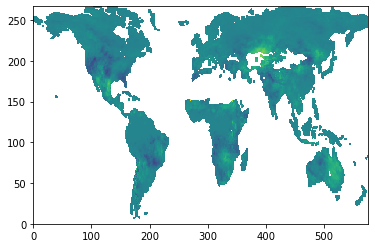

In [69]:
oni_raw = np.genfromtxt('oni.csv', delimiter=',')
#print(np.shape(oni_raw))
oni_list = []
for i in range(39):
    for j in range(12):
        oni_list.append(oni_raw[i,j])
ONI = np.array(oni_list[:464])
#print(len(ONI))



(39, 12)
464
-9.85935337106413e-06 0.3195165574417809
0.0017988220236655281


In [16]:
forest_cover = np.genfromtxt('deforestation.csv', delimiter = ',')
forest_cover_array = forest_cover[0]
deforestation = forest_cover_array - np.nanmean(forest_cover_array)

d_trend_slope, d_trend_intercept, d_trend_rvalue, d_trend_pvalue, d_trend_stderr = stats.linregress(year_from_start, deforestation)
#print(d_trend_slope, d_trend_pvalue)
deforestation_detrend = deforestation - d_trend_slope*year_from_start
#plt.plot(amazon_detrend)

In [199]:
print(np.shape(three_month_avg[:,:,1:]))
print(len(ONI[1:-2]))

(267, 576, 461)
461


In [215]:
m_coeff = np.empty([267, 576])

oni_fwi_point = np.empty([462])
for i in range(267):
    for j in range(576):
        oni_fwi_point = three_month_avg[i,j,:]
        #print(np.nanmean(fwi_point))
        if((~np.isnan(np.nanmean(oni_fwi_point)))):
            #print(np.nanmean(fwi_point))
            mask = ~np.isnan(oni_fwi_point[:]) & ~np.isnan(ONI[1:-1])
            m_coeff[i,j] = (np.corrcoef(ONI[1:-1][mask], oni_fwi_point[:][mask]))[0,1]
        else:
            m_coeff[i,j] = np.float('NaN')

<ipython-input-215-419c7c9740a7>:8: RuntimeWarning: Mean of empty slice
  if((~np.isnan(np.nanmean(oni_fwi_point)))):


In [212]:
print(len(years))
print(np.shape(yearly_array))
print(int(np.array(years)))

39
(267, 576, 39)


TypeError: only size-1 arrays can be converted to Python scalars

In [219]:
years_int = np.empty([39])
for i in range(len(years)):
    years_int[i] = int(years[i])
t_coeff = np.empty([267, 576])

oni_fwi_point = np.empty([39])
for i in range(267):
    for j in range(576):
        oni_fwi_point = yearly_array[i,j,:]
        #print(np.nanmean(fwi_point))
        if((~np.isnan(np.nanmean(oni_fwi_point)))):
            #print(np.nanmean(fwi_point))
            mask = ~np.isnan(oni_fwi_point[:]) & ~np.isnan(years_int)
            t_coeff[i,j] = (np.corrcoef(years_int[mask], oni_fwi_point[mask]))[0,1]
        else:
            t_coeff[i,j] = np.float('NaN')

<ipython-input-219-442c44695778>:11: RuntimeWarning: Mean of empty slice
  if((~np.isnan(np.nanmean(oni_fwi_point)))):


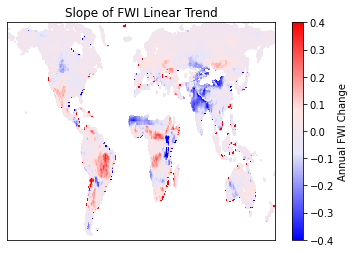

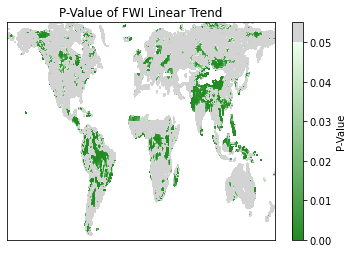

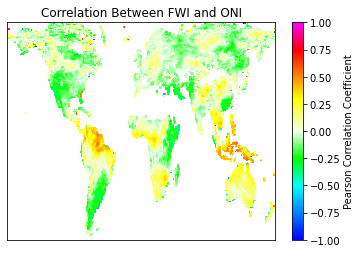

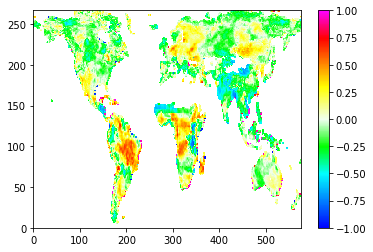

In [231]:
plt.figure(1)
colors1 = ['blue', 'lavender','mistyrose', 'red']
nodes1 = [0.0, 0.4, 0.6, 1.0]
cmap1 = LinearSegmentedColormap.from_list('mycmap', list(zip(nodes1,colors1)))
plt.pcolormesh(t_trend_slope*365.25,cmap = cmap1, vmin=-0.4, vmax=0.4)
plt.colorbar(label = 'Annual FWI Change')
plt.title('Slope of FWI Linear Trend')
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.figure(2)
colors2 = ['forestgreen', 'honeydew','lightgrey', 'lightgrey']
nodes2 = [0.0,11/12, 11/12, 1.0]
cmap2 = LinearSegmentedColormap.from_list('mycmap', list(zip(nodes2,colors2)))
plt.pcolormesh(t_trend_pvalue, cmap = cmap2, vmin=0, vmax=0.055)
plt.colorbar(label = 'P-Value')
plt.title('P-Value of FWI Linear Trend')
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.figure(3)
colors3 = ['blue','cyan', 'lime','honeydew','yellow','red','magenta']
nodes3 = [0,.25,.375,.5,.65,.875,1]
cmap3 = LinearSegmentedColormap.from_list('mycmap', list(zip(nodes3,colors3)))
plt.pcolormesh(m_coeff, vmin=-1, vmax=1, cmap = cmap3)
plt.colorbar(label = 'Pearson Correlation Coefficient')
plt.title('Correlation Between FWI and ONI')
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.figure(4)
plt.pcolormesh(t_coeff, vmin=-1, vmax=1, cmap = cmap3)
plt.colorbar()

In [232]:
ncfile.close()

RuntimeError: NetCDF: Not a valid ID

In [233]:

ncfile = Dataset('aggregate_data.nc', mode = 'w', format = 'NETCDF4_CLASSIC')
lat_dim = ncfile.createDimension('lat', 267)
lon_dim = ncfile.createDimension('lon', 576)
month_dim = ncfile.createDimension('month', 462)
year_dim = ncfile.createDimension('year', 39)
ncfile.title = 'Aggregated FWI Data'
ncfile.subtitle = 'Organized into a running three month average timeseries and a yearly average timeseries. Monthly data has linear trend and seasonal cycle removed, Yearly data has linear trend removed.'
lat = ncfile.createVariable('lat', np.float32, ('lat',))
lat.units = 'degrees_north'
lat.long_name = 'latitude'
lon = ncfile.createVariable('lon',np.float32, ('lon',))
lon.units = 'degrees_east'
lon.long_name = 'longitude'
month = ncfile.createVariable('month', np.int32, ('month',))
month.units = 'yyyymm'
month.long_name = 'Month and Year of Monthly Data'
year = ncfile.createVariable('year', np.int32, ('year',))
month.units = 'yyyy'
yFWI = ncfile.createVariable('yFWI', np.float32, ('lat', 'lon', 'year'))
yFWI.units = 'Unitless'
yFWI.long_name = 'Annual average global fire weather index'
mFWI = ncfile.createVariable('mFWI', np.float32, ('lat', 'lon', 'month'))
mFWI.units = 'Unitless'
mFWI.long_name = '3 month running average global fire weather index'
yFWI[:,:,:] = yearly_array[:,:,:]
mFWI[:,:,:] = three_month_avg[:,:,:]
lat[:] = sample['lat'][:]
lon[:] = sample['lon'][:]
month[:] = nc_date_key[12:-2]
year[:] = years_int
ncfile.close()

PermissionError: [Errno 13] Permission denied: b'aggregate_data.nc'

<ipython-input-184-1a38ca8dc26a>:2: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  print(test_nc['mFWI'])


<class 'netCDF4._netCDF4.Variable'>
float32 mFWI(lat, lon, month)
    units: Unitless
    long_name: 3 month running average global fire weather index
unlimited dimensions: 
current shape = (267, 576, 462)
filling on, default _FillValue of 9.969209968386869e+36 used


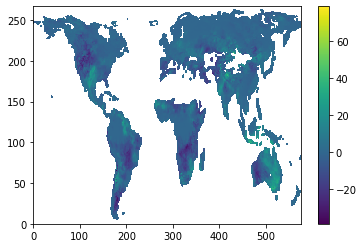

In [184]:
test_nc = nc.Dataset('aggregate_data.nc')
print(test_nc['mFWI'])
plt.pcolormesh(test_nc['mFWI'][:,:,8])
plt.colorbar()